In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras import models

In [2]:
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [3]:
img_path = '/home/tuffy/Documents/CholletDL/cats_and_dogs_small/test/cats/cat.1700.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size = (150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


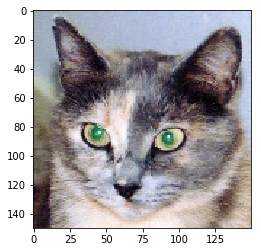

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [5]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

In [6]:
activations = activation_model.predict(img_tensor)

In [7]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


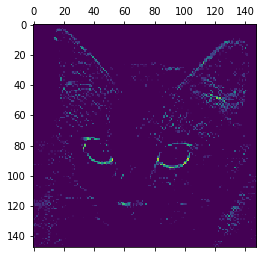

In [8]:
plt.matshow(first_layer_activation[0,:, :, 4], cmap = 'viridis')

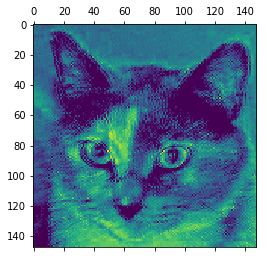

In [9]:
plt.matshow(first_layer_activation[0,:, :, 7], cmap = 'viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


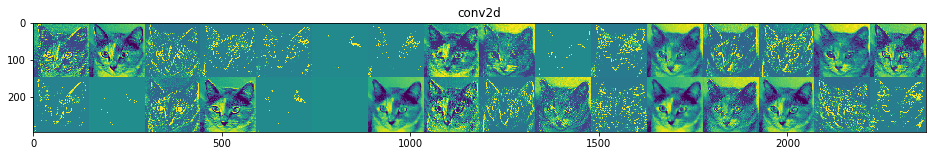

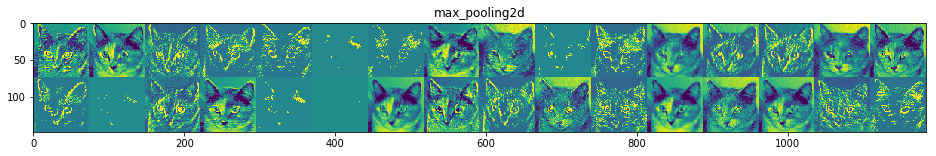

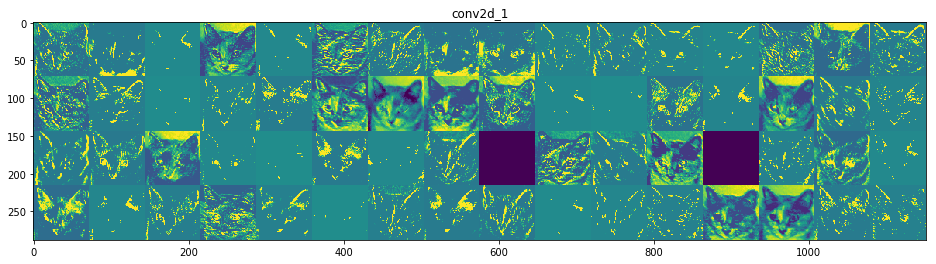

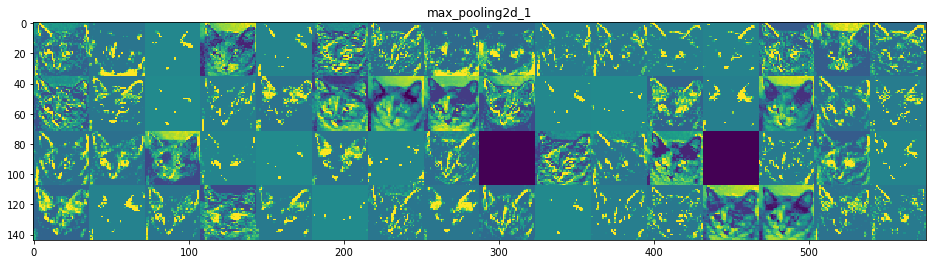

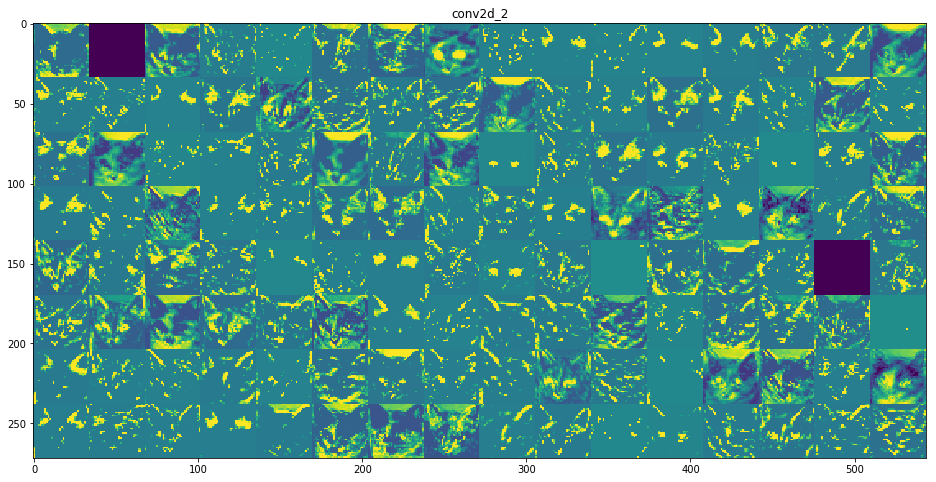

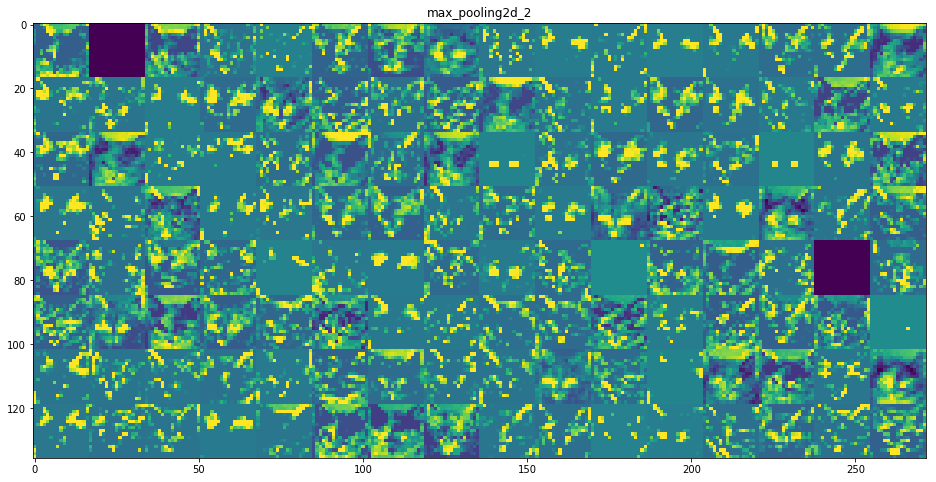

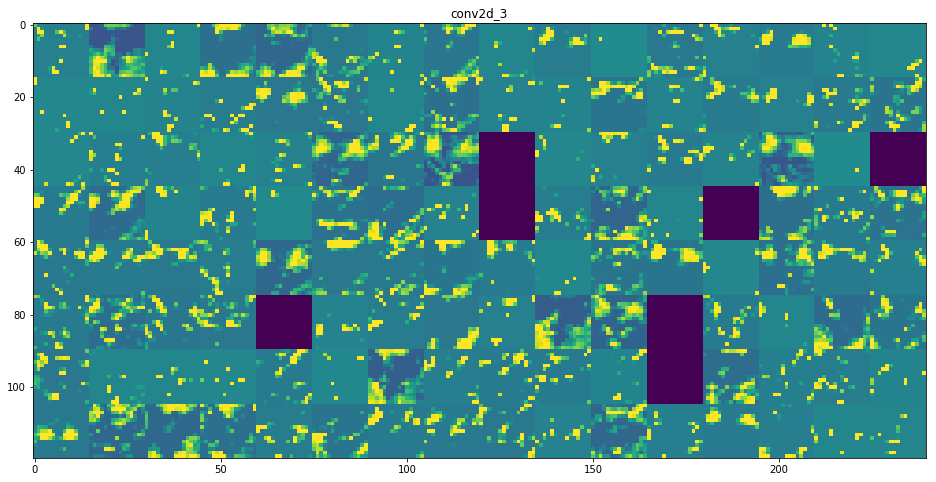

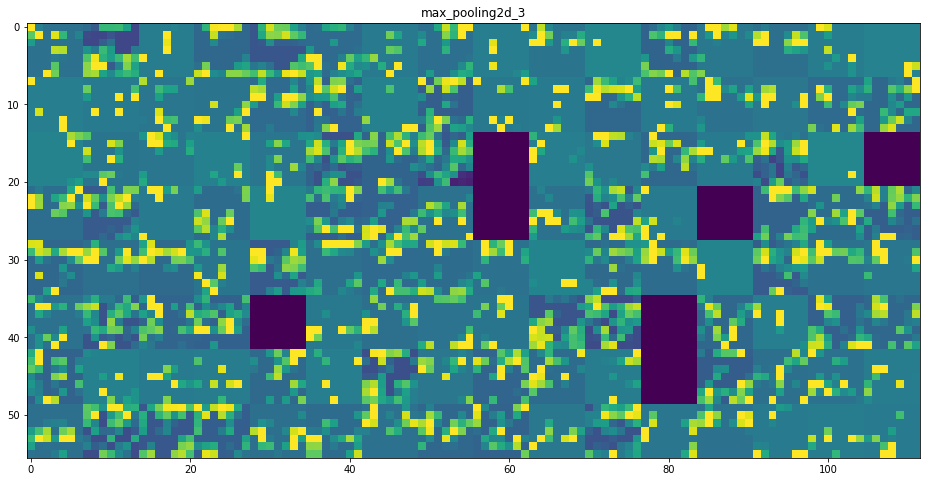

In [10]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size : (col +1) * size, row * size : (row + 1) * size] = channel_image
        
    scale = 1./ size
    plt.figure(figsize =(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

In [12]:
disable_eager_execution()

In [13]:
model = VGG16(weights = 'imagenet', include_top = False)

layer_name = 'block3_conv1'
filter_index= 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:, filter_index])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1,150,150,3))])

In [20]:
input_img_data = np.random.random((1,150,150, 3)) * 20 +128.
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value *step

In [21]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std()+ 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x += 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [22]:
def generate_pattern(layer_name, filter_index, size = 150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input],[loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value *step
    
    img = input_img_data[0]
    return deprocess_image(img)

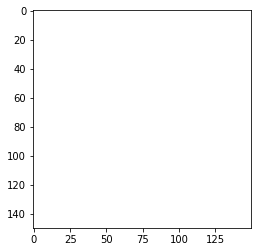

In [23]:
plt.imshow(generate_pattern('block3_conv1', 0))